# TP : Réponse impulsionnelle de salle

\tableofcontents

In [9]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import wavio
import scipy.io as sio
import datetime
from scipy import signal
from scipy.fft import fft, fftfreq

## Simulation de l'effet de réverbération

1. Pour simuler le signal audio dans les différents environnements, on peut utiliser leur réponse impulsionnelle et la convoluer avec notre signal audio de chant enregistré dans une chambre anéchoïque. Ce type d'enregistrement permet de ne pas polluer notre signal d'entré avec la réponse impulsionnelle de la pièce d'enregistrement.

In [70]:
#vitesse du son
c=340; 

# signal émis
name_source = 'assets/singing.wav'

# RI
RI_nashville = 'assets/1st_baptist_nashville_far_wide.wav'
RI_university ='assets/auditorium-university-s1r2_0_1.wav'
RI_sportcentre ='assets/sportscentre_omni.wav';

# Lecture des données
fs, source = sio.wavfile.read(name_source)
fs_h_nashville, h_nashville = sio.wavfile.read(RI_nashville)
fs_h_university, h_university = sio.wavfile.read(RI_university)
fs_h_sportcentre, h_sportcentre = sio.wavfile.read(RI_sportcentre)

# Conversion en float
source = np.float64(source)
ho_nashville = np.float64(h_nashville)[:,0] # on garde 1 canal si plusieurs canaux
ho_university = np.float64(h_university)[:,0] # on garde 1 canal si plusieurs canaux
ho_sportcentre = np.float64(h_sportcentre)

# Réecchantillonage de la RI 
# (les deux signaux n'ont pas la même fréquence d'échantillonnage)
h_nashville = signal.resample(ho_nashville, int(len(ho_nashville)*fs/fs_h_nashville))
h_university = signal.resample(ho_university, int(len(ho_university)*fs/fs_h_university))
h_sportcentre = signal.resample(ho_sportcentre, int(len(ho_sportcentre)*fs/fs_h_sportcentre))

singing_nashville = signal.convolve(source, h_nashville, mode='full')
singing_university = signal.convolve(source, h_university, mode='full')
singing_sportcentre = signal.convolve(source, h_sportcentre, mode='full')

/tmp/ipykernel_3626/2241597930.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, source = sio.wavfile.read(name_source)
/tmp/ipykernel_3626/2241597930.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_h_nashville, h_nashville = sio.wavfile.read(RI_nashville)
/tmp/ipykernel_3626/2241597930.py:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_h_university, h_university = sio.wavfile.read(RI_university)
/tmp/ipykernel_3626/2241597930.py:16: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_h_sportcentre, h_sportcentre = sio.wavfile.read(RI_sportcentre)


2. Une fois les signaux simuler dans les environnements on peut les écouter afin de comprendre comment l'environnement affecte le signal d'origine.

In [25]:
# Restitution audio
print('Playing Singing in Nashville environnement')
sd.play(singing_nashville/max(singing_nashville),fs,blocking=True)

Playing Singing in Nashville environnement


In [26]:
# Restitution audio
print('Playing Singing in University environnement')
sd.play(singing_university/max(singing_university),fs,blocking=True)

Playing Singing in University environnement


In [27]:
# Restitution audio
print('Playing Singing in Sportcentre environnement')
sd.play(singing_sportcentre/max(singing_sportcentre),fs,blocking=True)

Playing Singing in Sportcentre environnement


On remarque qu'en fonction des différents environnements l'effet de réverbération est très différent. Plus la pièce est un espace vide plus l'effet est notable. Par exemple, c'est dans le gymnase qu'il est le plus fort et à l'inverse il est le moins prononcé dans l'auditorium d'univerité. On peut aussi remarquer qu'un effet de réverbération trop important limite la clarté et donc la compréhension du son par l'observeur.

3. Pour expliquer ces différences, on peut analyser les réponses en fréquences des différents environnements.

In [71]:
def show_RI_fft(ri: np.ndarray, name: str):
    # FFT de la RI
    fft_result = fft(ri,len(ri)*10)
    fft_freqs = fftfreq(len(ri)*10, 1/fs)  # Fréquences correspondantes
    fft_amplitude = np.abs(fft_result)
    
    plt.figure()
    plt.plot(fft_freqs, fft_amplitude)
    plt.title("Réponse en fréquence de la salle - " + name)
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, fs/2) 
    plt.show()

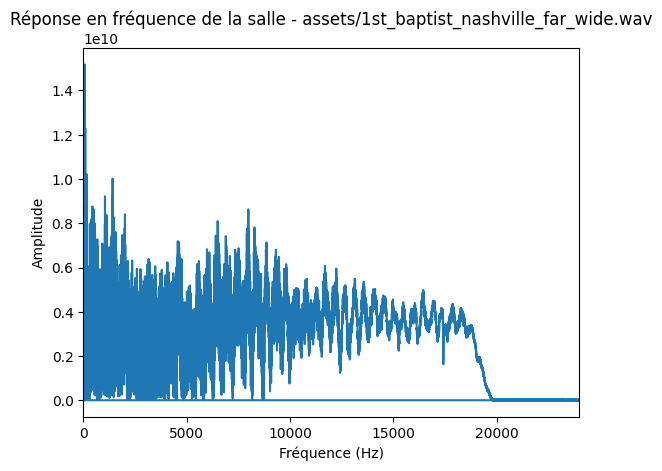

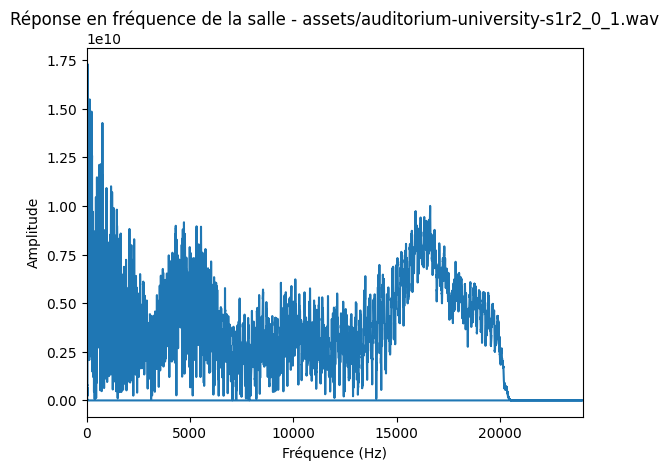

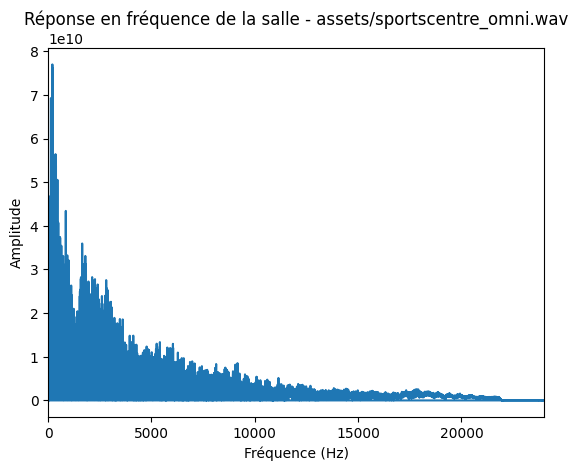

In [72]:
show_RI_fft(h_nashville, RI_nashville)
show_RI_fft(h_university, RI_university)
show_RI_fft(h_sportcentre, RI_sportcentre)

On peut voir que les deux réponses sont très différentes. En effets la salle de sport amplifie les basses fréquences et ne semble pas avoir d'objectif particulier. A l'inverse, dans l'église, on voit une amplification moins forte mais plus constante dans la plage de sensibilité de l'oreil humaine. En vu du lieu, cette réponse semble être voulu pour avoir une propagration agréable et audible d'un signal émis (un chant par exemple). Il en est de même pour l'auditorium d'université.

## Validation par simulation
### Simulation d'une mesure

1. D'abord, on commence par générer un signal de bruit blanc pour utiliser en signal émis.

In [73]:
# Paramètres
T = 10  # secondes
fs = 44000  # Hz
c = 340  # vitesse du son

# signal source
N = int(T * fs)
noise = np.random.randn(N)
noise = noise/max(abs(noise)) # normalisation

2. Pour simuler le signal reçu dans un environnement réverbérant on peut convoluer le signal dans un réponse de salle utilisée dans la partie précédente.

In [74]:
h_nashville = signal.resample(ho_nashville, int(len(ho_nashville)*fs/fs_h_nashville))
noise_nashville = signal.convolve(noise, h_nashville, mode='full')

In [15]:
# Restitution audio
print('Playing Noise in Nashville environnement')
sd.play(noise_nashville/max(noise_nashville),fs,blocking=True)

Playing Noise in Nashville environnement


### Estimation de la réponse impulsionnelle de la salle

1. Pour estimer la réponse impulsionnelle, on peut émettre un bruit blanc dans la salle que l'on veut caractériser et lire le signal reçu. En calculant l'intercorrelation entre les deux signaux émis et reçu on trouvera la réponse impulsionnelle de la salle.

In [75]:
estimation_og = signal.correlate(noise_nashville, noise, mode='full')

2. 

(-0.01, 0.3)

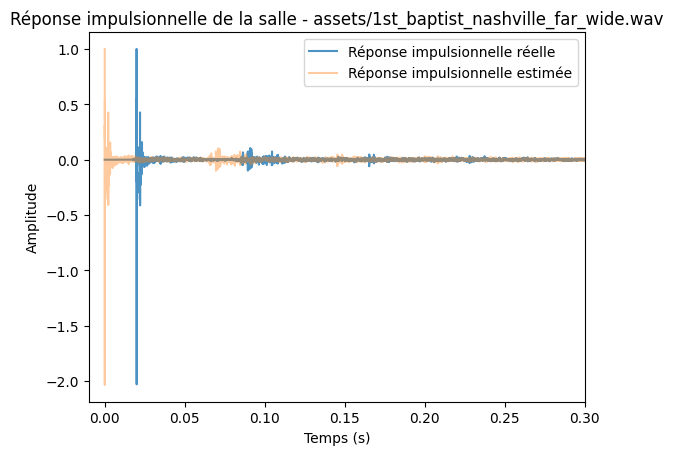

In [77]:
th = np.arange(0, len(h_nashville))/fs  # Fréquences correspondantes

first_max_value = np.argmax(estimation_og)
estimation = estimation_og[first_max_value:]
estimation = estimation[:len(h_nashville)]

plt.figure()
plt.plot(th, h_nashville/max(h_nashville), alpha=0.8, label="Réponse impulsionnelle réelle")
plt.plot(th, estimation/max(estimation), alpha=0.4, label="Réponse impulsionnelle estimée")
plt.title("Réponse impulsionnelle de la salle - " + RI_nashville)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(-0.01, 0.3)

On voit que la réponse estimée est similaire à la réponse réelle enregistrée. Il y a un effet d'échelle, (les deux signaux n'ont pas la même amplitude) et de translation (le signal n'est pas situé au même temps). Pour autant, on retrouve les mêmes lobes au alentours de 0.1s et un peu avant 0.2s. C'est ces piques qui constituent les échos entendus. Ainsi, s'ils ont un emplacement et une amplitude similaire par rapport à la réponse impulsionnelle d'origine (en 0) alors le son émis aura la même sonorité. Ce n'est pas forcément important d'avoir la même amplitude absolue car elle est relative à la puissance du signal émis pour la mesure et des conditions d'observation.

3. Pour ajouter un bruit avec un RSB connu on peut calculer la puissance du bruit avec la formule suivante: $P_{noise}=\frac{P_{signal}}{RSB}$. Pour convertir le RSB exprimer en dB, il faut le linériser avec $RSB=10^{\frac{RSB_{dB}}{10}}$. Une fois la puissance du bruit trouver on peut prendre le carré de cette valeur pour trouver l'écart-type de la distribution que l'on veut pour notre bruit de mesure.

In [78]:
def add_measure_noise_RSB(signal: np.ndarray, RSB: int) -> np.ndarray:
    signal_power = np.var(signal)
    noise_power = signal_power / 10**(RSB/10)
    noise = np.random.normal(0, np.square(noise_power), len(signal))
    return signal + noise

4. Nous allons maintenant étudier l'impact du RSB et de la durée d'émission du signal.

In [79]:
RSBs = [-15, -10, 10]
noise_nashville_norm = noise_nashville/max(noise_nashville)

estimations = []
for RSB in RSBs:
    noise_nashville_measure_noise = add_measure_noise_RSB(noise_nashville_norm, RSB)

    estimation = signal.correlate(noise_nashville_measure_noise, noise, mode='full')
    first_max_value = np.argmax(estimation)
    estimation = estimation[first_max_value:]
    estimation = estimation[:len(h_nashville)-1]
    estimations.append(estimation)

(-0.2, 0.2)

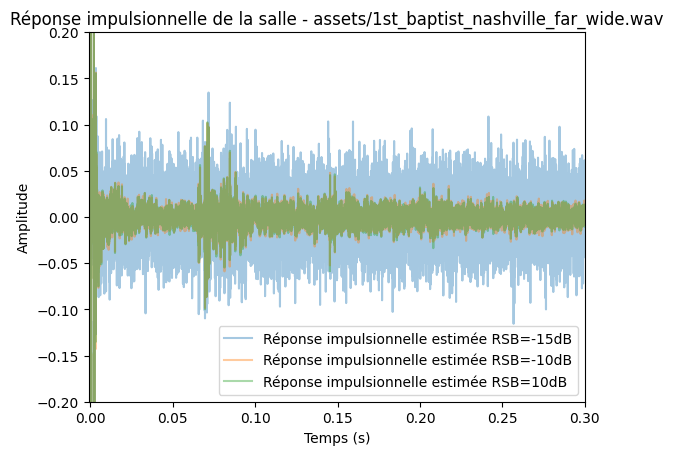

In [80]:
th = np.arange(0, len(estimations[0]))/fs  # Fréquences correspondantes

plt.figure()
for i, estimation in enumerate(estimations):
    plt.plot(th, estimation/max(estimation), alpha=0.4, label=f"Réponse impulsionnelle estimée RSB={RSBs[i]}dB")
plt.title("Réponse impulsionnelle de la salle - " + RI_nashville)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(-0.001, 0.3)
plt.ylim(-0.2, 0.2)

En augmentant la valeur RSB (Rapport Signal sur Bruit) on remarque que la précision de l'estimation de la réponse impulsionnelle de la salle est de plus en plus précise. En réalité la différence est plus visible pour les petits échos, qui, si le bruit est trop important ne seront pas pris en compte. Ainsi, au delà d'une certaine valeur de RSB la différence devient moins significative quant à la qualité de l'estimation.

Ce RSB peut être augmenter de deux manières, soit en réduisant le bruit dans l'environnement lors de la mesure et au niveau des intruments utilisés. Ou bien en augmentant la puissance du signal émis. C'est cette deuxième option que nous allons voir en jouant sur la durée d'enregistrement de notre bruit.

In [84]:
# Paramètres
Ts = [1, 10, 20]  # secondes
fs = 44000  # Hz
c = 340  # vitesse du son

noises = []
for T in Ts:
    N = int(T * fs)
    noise = np.random.randn(N)
    noise = noise/max(abs(noise)) # normalisation
    noises.append(noise)

In [85]:
estimations = []
RSB = -10

for noise in noises:
    noise_nashville = signal.convolve(noise, h_nashville, mode='full')
    noise_nashville_measure_noise = add_measure_noise_RSB(noise_nashville/max(noise_nashville), RSB)
    
    estimation = signal.correlate(noise_nashville_measure_noise, noise, mode='full')
    first_max_value = np.argmax(estimation)
    estimation = estimation[first_max_value:]
    estimation = estimation[:len(h_nashville)-1]
    estimations.append(estimation)

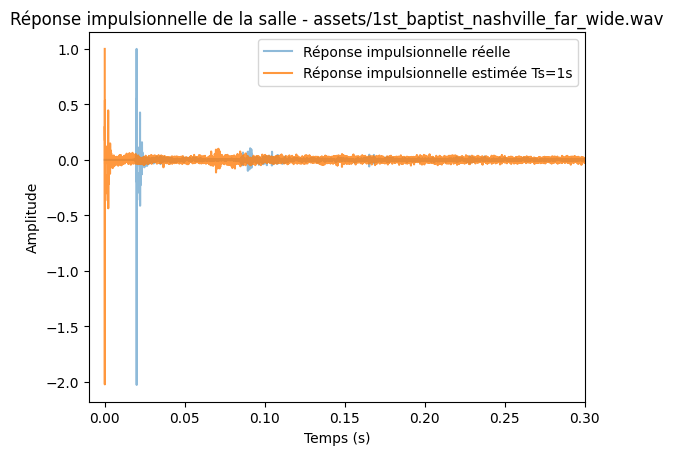

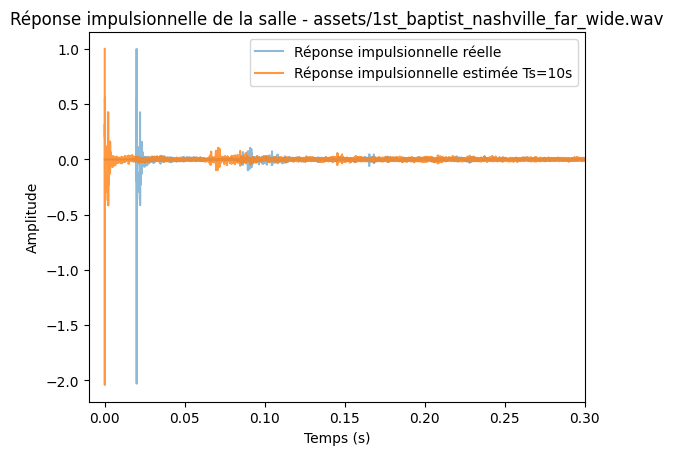

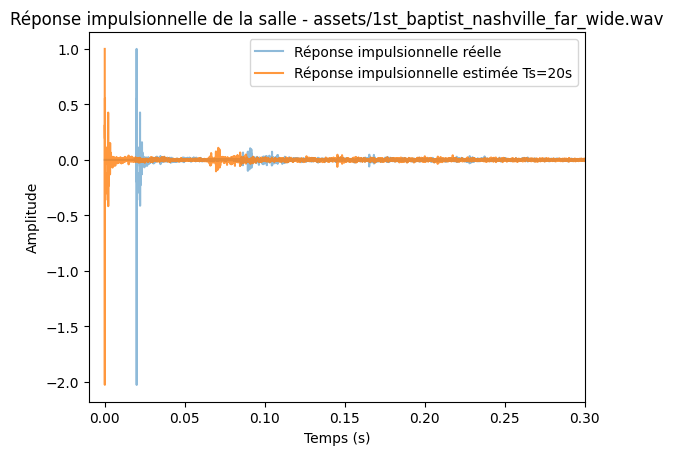

In [86]:
th = np.arange(0, len(estimations[0]))/fs  # Fréquences correspondantes
th2 = np.arange(0, len(h_nashville))/fs  # Fréquences correspondantes

for i, estimation in enumerate(estimations):
    plt.figure()
    plt.plot(th2, h_nashville/max(h_nashville), alpha=0.5, label="Réponse impulsionnelle réelle")
    plt.plot(th, estimation/max(estimation), alpha=0.8, label=f"Réponse impulsionnelle estimée Ts={Ts[i]}s")
    plt.title("Réponse impulsionnelle de la salle - " + RI_nashville)
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.xlim(-0.01, 0.3)

Commme attendu lors de l'étude de l'effet du rapport Signal-Bruit, l'augmentation du temps d'émission du bruit blanc pour l'estimation ajoute virtuellement de l'énergie à notre signal. Ce qui permet d'avoir un signal équivalent plus fort le rendant moins sensible au bruit. Cependant, l'augmentation de la durée d'enregistrement augmente également la difficuleté de traitement informatique car les données sont plus longues et donc plus volumineuses.

## Validation expérimentale

### Mesure de la réponse impulsionnelle de la salle

1. Grâce au script fourni, on peut faire une mesure réel d'un bruit et de son écoute dans un salle. 

In [132]:
# signal émis
name_source = 'assets/mesures/240927 11-54-source.wav'

# signal reçu
name_mesure = 'assets/mesures/240927 11-54-mesure.wav'

# Lecture des données
fs, source = sio.wavfile.read(name_source)
fs_mesure, mesure = sio.wavfile.read(name_mesure)

# Conversion en float
source = np.float64(source)
mesure = np.float64(mesure)[:,0]

# Réecchantillonage
mesure = signal.resample(mesure, int(len(mesure)*fs/fs_mesure))

2. Pour estimer la réponse impulsionnelle de la salle, on peut utiliser notre fonction d'estimation vue précédemment.

In [133]:
estimation_og = signal.correlate(mesure, source, mode='full')

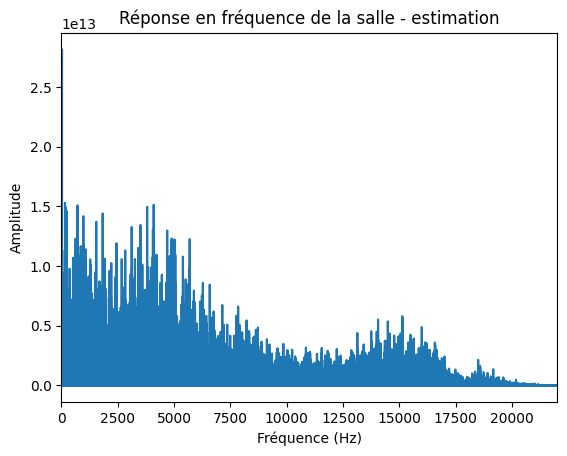

In [134]:
show_RI_fft(estimation_og, "estimation")

(-0.01, 0.4)

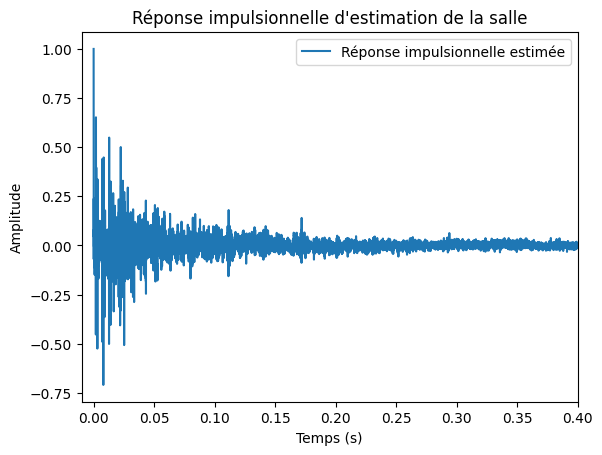

In [139]:
# Alignement de la réponse à zéro
first_max_value = np.argmax(estimation_og)
estimation = estimation_og[first_max_value:]
estimation = estimation[:len(h_nashville)-1]

# Temps correspondants
th = np.arange(0, len(estimation))/fs_mesure

plt.figure()
plt.plot(th, estimation/max(estimation), label=f"Réponse impulsionnelle estimée")
plt.title("Réponse impulsionnelle d'estimation de la salle")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(-0.01, 0.4)

Quand on regarde la réponse en fréquence de la réponse impulsionnelle estimée, on remarque qu'elle se rapproche de la réponse impulsionnel de notre gymnase utilisé dans les premières parties du TP. Puis, sur la réponse impulsionelle, on peut remarquer que la réponse est bruité, en réalité il s'agit en partie des échos.

3.

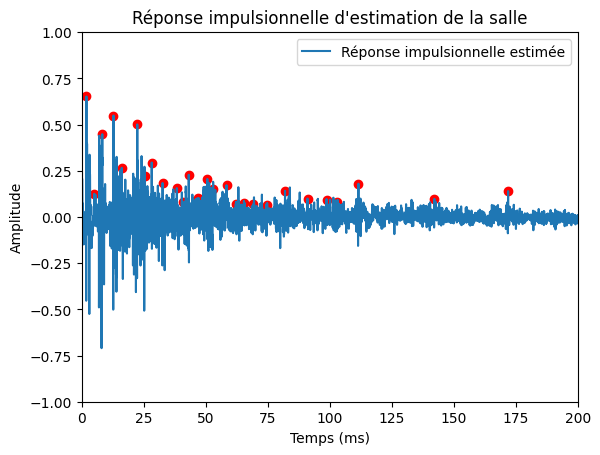

array([  1.93181818,   5.06818182,   8.31818182,  12.84090909,
        16.15909091,  19.90909091,  22.43181818,  25.40909091,
        28.25      ,  32.63636364,  36.        ,  38.36363636,
        40.68181818,  43.18181818,  47.11363636,  50.68181818,
        53.13636364,  55.59090909,  58.40909091,  62.15909091,
        65.59090909,  69.20454545,  72.22727273,  74.72727273,
        82.        ,  86.77272727,  91.06818182,  98.88636364,
       103.02272727, 111.61363636, 142.22727273, 171.95454545])

In [184]:
estimation_norm = estimation/max(estimation)
peaks, _ = signal.find_peaks(estimation_norm, threshold=0.02, distance=100)

plt.figure()
plt.plot(th*1000, estimation_norm, label=f"Réponse impulsionnelle estimée")
plt.scatter(th[peaks]*1000, estimation_norm[peaks], color="red")
plt.title("Réponse impulsionnelle d'estimation de la salle")
plt.xlabel("Temps (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(0, 200)
plt.ylim(-1, 1)
plt.show()
th[peaks]*1000

Pour ces premiers échos on peut estimer à quel distance ils correspondent grâce aux mesures de la salle.

![mesure_geometrie]("./assets/mesures/geometrie.jpg")

On calculera à l'aide de trigonométrie de base les différentes distances parcourues pour les échos rebondissant une fois:
- Echo sur un des murs gauche ou droit : $d\approx10.92m$
- Echo sur le plafond : $d\approx4.53m$
- Echo sur le sol : $d\approx4.92m$
- Echo sur le mur à l'arrière du micro : $d\approx8.4m$
- Echo sur le mur à l'arrière du récepteur : $d\approx6.3m$

D'où un décalage temporelle de $n=\frac{d_{micro_recepteur}-d_{parcourue}}{c}$:
- Echo sur un des murs gauche ou droit : $\Delta{t}\approx20.65ms$
- Echo sur le plafond : $\Delta{t}\approx1.85ms$
- Echo sur le sol : $\Delta{t}\approx3ms$
- Echo sur le mur à l'arrière du micro : $\Delta{t}\approx13.24ms$
- Echo sur le mur à l'arrière du récepteur : $\Delta{t}\approx7.06ms$

On remarque que le décalage temporelle est très petit et donc sensible au variation de mesure et d'estimation. Cependant, on retrouve certains écho dans notre tableau de piques. D'abord, l'écho sur le plafond qui est le premier à arriver après le signal en ligne directe. Puis, l'écho sur le sol est relativement différent de la mesure attendue, on peut aussi retrouver l'écho sur le mur à l'arrière du micro autour de 13ms et enfin sur le mur à l'arrière du récepteur vers 7/8ms. On trouvera ensuite toute les compositions et rebond multiples.

Pour estimer la distance entre les réflecteurs on pourra prendre la différence entre le temps d'émission et de réception.

In [ ]:
#TODO